In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets

from tqdm import trange

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
encoding_dim = 2
input_dim = 28*28
label_dim = 10
batch_size = 512
epochs = 100
discriminator_multiplier = .1

generator_layers = [input_dim, 512, 512, encoding_dim]
discriminator_layers = [encoding_dim, 512, 512, 512, 512, 1]

In [5]:
class Encoder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                return layer(x)
            else:
                x = torch.relu(layer(x))

In [6]:
class Decoder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[-i-1], layers[-i-2]))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                return torch.sigmoid(layer(x))
            else:
                x = torch.relu(layer(x))

In [7]:
class AE(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.encoder = Encoder(layers)
        self.decoder = Decoder(layers)
    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

In [8]:
class Discriminator(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                return torch.sigmoid(layer(x))
            else:
                x = torch.relu(layer(x))

In [9]:
# Datasets
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = datasets.MNIST(
   root="./mnist",
   train=True,
   transform=transform,
   download=True,
)

test_dataset = datasets.MNIST(
   root="./mnist",
   train=False,
   transform=transform,
   download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [10]:
generator = AE(generator_layers)
discriminator = Discriminator(discriminator_layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

lr = 1e-3
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

generator_loss_function = nn.MSELoss()
discriminator_loss_function = nn.BCELoss()

In [11]:
def valid(size):
    return torch.ones([size, 1]).to(device)


def invalid(size):
    return torch.zeros([size, 1]).to(device)


def real_distribution(size):
    return torch.normal(0, 2, size=(size, encoding_dim)).to(device)

In [893]:
for epoch in trange(epochs):
    print(f"Epoch {epoch+1}")
    generator_total = 0
    discriminator_total = 0
    sub_reconstruction = 0
    sub_discriminator = 0
    for batch_features, batch_labels in train_loader:

        # Resize batch_features
        batch_features = batch_features.view(-1, 784).to(device)
        size = batch_features.size()[0]

        ########### TRAIN GENERATOR ###########

        # Reset the gradients back to zero
        generator.zero_grad()

        # Freeze the discriminator
        discriminator.eval()
        scripted_model = torch.jit.script(discriminator)
        frozen_discriminator = torch.jit.freeze(scripted_model)

        # Run examples through generator
        encoded, reconstructed = generator(batch_features)

        # Compute reconstruction loss
        reconstruction_loss = generator_loss_function(reconstructed, batch_features)

        # Compute discriminator loss
        validity = frozen_discriminator(encoded)
        discriminator_loss = discriminator_loss_function(validity, valid(size))
        discriminator_loss = discriminator_loss * discriminator_multiplier

        # Sum loss
        generator_loss = reconstruction_loss + discriminator_loss

        # Backwards loss and step optimizer
        generator_loss.backward()
        generator_optimizer.step()

        # Add minibatch to epoch_loss
        generator_total += generator_loss.item()
        sub_reconstruction += reconstruction_loss.item()
        sub_discriminator += discriminator_loss.item()

        ######### TRAIN DISCRIMINATOR #########

        # Reset the gradients back to zero
        discriminator.zero_grad()

        # Freeze the encoder
        generator.encoder.eval()
        scripted_model = torch.jit.script(generator.encoder)
        frozen_encoder = torch.jit.freeze(scripted_model)   

        # Get a fake discribution from the frozen_generator
        fake_distribution = frozen_encoder(batch_features)

        # Calculate loss from fake discributions
        validity = discriminator(fake_distribution)
        fake_loss = discriminator_loss_function(validity, invalid(size))

        # Calculate loss from real discributions
        validity = discriminator(real_distribution(size))
        real_loss = discriminator_loss_function(validity, valid(size))

        # Sum loss
        discriminator_loss = real_loss + fake_loss

        # Backwards loss and step optimizer
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Add minibatch to epoch loss
        discriminator_total += discriminator_loss.item()
    
    # Calculate total loss
    generator_total = generator_total / len(train_loader)
    discriminator_total = discriminator_total / len(train_loader)
    sub_reconstruction = sub_reconstruction / len(train_loader)
    sub_discriminator = sub_discriminator / len(train_loader)
    print(f"Generator Loss: {generator_total}, Discriminator Loss: {discriminator_total}")
    print(f"sub_reconstruction: {sub_reconstruction}, sub_discriminator, {sub_discriminator}")

# Save models
torch.save(generator, '7-14_generator.pt')
torch.save(discriminator, '7-14_discriminator.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1


  1%|          | 1/100 [00:21<35:20, 21.42s/it]

Generator Loss: 0.4358077305605856, Discriminator Loss: 0.3675826660404771
sub_reconstruction: 0.07155719146890155, sub_discriminator, 0.36425053877598146
Epoch 2


  2%|▏         | 2/100 [00:29<22:12, 13.59s/it]

Generator Loss: 0.27162865170482864, Discriminator Loss: 0.6984300057766801
sub_reconstruction: 0.06017743183647172, sub_discriminator, 0.2114512204366215
Epoch 3


  3%|▎         | 3/100 [00:37<17:47, 11.01s/it]

Generator Loss: 0.1672883465633554, Discriminator Loss: 1.0797366065494085
sub_reconstruction: 0.05540368734401161, sub_discriminator, 0.11188465925091404
Epoch 4


  4%|▍         | 4/100 [00:45<15:43,  9.83s/it]

Generator Loss: 0.12444340342939911, Discriminator Loss: 1.3669495855347584
sub_reconstruction: 0.052373336628079414, sub_discriminator, 0.07207006689603046
Epoch 5


  5%|▌         | 5/100 [00:53<14:34,  9.20s/it]

Generator Loss: 0.12282139334385678, Discriminator Loss: 1.3785776556548426
sub_reconstruction: 0.05192344780948203, sub_discriminator, 0.0708979459447881
Epoch 6


  6%|▌         | 6/100 [01:01<13:46,  8.79s/it]

Generator Loss: 0.12074928737040293, Discriminator Loss: 1.38231395462812
sub_reconstruction: 0.050482268745111206, sub_discriminator, 0.07026701837272967
Epoch 7


  7%|▋         | 7/100 [01:09<13:14,  8.54s/it]

Generator Loss: 0.11983632769877628, Discriminator Loss: 1.386512298705214
sub_reconstruction: 0.04942713400064889, sub_discriminator, 0.07040919382440841
Epoch 8


  8%|▊         | 8/100 [01:17<12:48,  8.35s/it]

Generator Loss: 0.11836364707451756, Discriminator Loss: 1.3858024791135626
sub_reconstruction: 0.04848368289106983, sub_discriminator, 0.06987996399402618
Epoch 9


  9%|▉         | 9/100 [01:25<12:34,  8.29s/it]

Generator Loss: 0.11739178450178292, Discriminator Loss: 1.385542878660105
sub_reconstruction: 0.047928082740913, sub_discriminator, 0.06946370195029146
Epoch 10


 10%|█         | 10/100 [01:34<12:52,  8.59s/it]

Generator Loss: 0.11726875306438592, Discriminator Loss: 1.3855185145038669
sub_reconstruction: 0.0475392770653559, sub_discriminator, 0.06972947609374079
Epoch 11


 11%|█         | 11/100 [01:45<13:26,  9.07s/it]

Generator Loss: 0.11634707147792234, Discriminator Loss: 1.3848974260233216
sub_reconstruction: 0.04686425253748894, sub_discriminator, 0.06948281868787134
Epoch 12


 12%|█▏        | 12/100 [01:55<14:00,  9.55s/it]

Generator Loss: 0.11561733332730956, Discriminator Loss: 1.385696017136008
sub_reconstruction: 0.046235887681023546, sub_discriminator, 0.06938144589884807
Epoch 13


 13%|█▎        | 13/100 [02:10<16:13, 11.19s/it]

Generator Loss: 0.11506388184882826, Discriminator Loss: 1.3854732210353269
sub_reconstruction: 0.045615238405890386, sub_discriminator, 0.06944864350607839
Epoch 14


 14%|█▍        | 14/100 [02:22<16:05, 11.23s/it]

Generator Loss: 0.1150565761757099, Discriminator Loss: 1.385595576237824
sub_reconstruction: 0.04516977362208447, sub_discriminator, 0.06988680249048491
Epoch 15


 15%|█▌        | 15/100 [02:30<14:42, 10.38s/it]

Generator Loss: 0.11372278996948469, Discriminator Loss: 1.3839151818873519
sub_reconstruction: 0.04458143309516422, sub_discriminator, 0.06914135630605585
Epoch 16


 16%|█▌        | 16/100 [02:38<13:33,  9.69s/it]

Generator Loss: 0.11399142658811505, Discriminator Loss: 1.3852109414035991
sub_reconstruction: 0.044374050256811966, sub_discriminator, 0.06961737655229487
Epoch 17


 17%|█▋        | 17/100 [02:46<12:51,  9.29s/it]

Generator Loss: 0.11370849830366797, Discriminator Loss: 1.3843449647143735
sub_reconstruction: 0.04390693023422007, sub_discriminator, 0.0698015678484561
Epoch 18


 18%|█▊        | 18/100 [02:55<12:12,  8.93s/it]

Generator Loss: 0.11362052456302157, Discriminator Loss: 1.3857178071797904
sub_reconstruction: 0.04388657234356565, sub_discriminator, 0.0697339523141667
Epoch 19


 19%|█▉        | 19/100 [03:03<12:02,  8.92s/it]

Generator Loss: 0.1136075874506417, Discriminator Loss: 1.3854977185443296
sub_reconstruction: 0.04358171450637155, sub_discriminator, 0.07002587256542707
Epoch 20


 20%|██        | 20/100 [03:12<11:46,  8.83s/it]

Generator Loss: 0.11332150555010569, Discriminator Loss: 1.3841000259932825
sub_reconstruction: 0.04334209275321435, sub_discriminator, 0.06997941251275903
Epoch 21


 21%|██        | 21/100 [03:24<12:42,  9.65s/it]

Generator Loss: 0.11242874257140241, Discriminator Loss: 1.3845252627033298
sub_reconstruction: 0.04262452057988967, sub_discriminator, 0.06980422240192607
Epoch 22


 22%|██▏       | 22/100 [03:32<12:11,  9.37s/it]

Generator Loss: 0.11220423220577887, Discriminator Loss: 1.3848288049132138
sub_reconstruction: 0.04244604406846782, sub_discriminator, 0.06975818810574079
Epoch 23


 23%|██▎       | 23/100 [03:41<11:39,  9.09s/it]

Generator Loss: 0.11145043265769038, Discriminator Loss: 1.3847201224100791
sub_reconstruction: 0.04200637372115911, sub_discriminator, 0.0694440586208287
Epoch 24


 24%|██▍       | 24/100 [03:49<11:06,  8.77s/it]

Generator Loss: 0.1117780406848859, Discriminator Loss: 1.384109700130204
sub_reconstruction: 0.041911076849042356, sub_discriminator, 0.06986696348857072
Epoch 25


 25%|██▌       | 25/100 [03:57<10:42,  8.57s/it]

Generator Loss: 0.11103460369473797, Discriminator Loss: 1.3843691803641238
sub_reconstruction: 0.04165654285353119, sub_discriminator, 0.06937806043079343
Epoch 26


 26%|██▌       | 26/100 [04:07<11:14,  9.11s/it]

Generator Loss: 0.1111360303426193, Discriminator Loss: 1.3854002346426755
sub_reconstruction: 0.041261729105549344, sub_discriminator, 0.06987430111078893
Epoch 27


 27%|██▋       | 27/100 [04:18<11:52,  9.76s/it]

Generator Loss: 0.11097909106036365, Discriminator Loss: 1.3849094984895092
sub_reconstruction: 0.04110267729956215, sub_discriminator, 0.06987641391865278
Epoch 28


 28%|██▊       | 28/100 [04:26<11:04,  9.23s/it]

Generator Loss: 0.11039085010603322, Discriminator Loss: 1.3845572714078225
sub_reconstruction: 0.04090867845057431, sub_discriminator, 0.06948217168702918
Epoch 29


 29%|██▉       | 29/100 [04:34<10:26,  8.83s/it]

Generator Loss: 0.1104870799739482, Discriminator Loss: 1.3843462830882962
sub_reconstruction: 0.04059342174964436, sub_discriminator, 0.06989365809802282
Epoch 30


 30%|███       | 30/100 [04:42<09:55,  8.51s/it]

Generator Loss: 0.10949913614382178, Discriminator Loss: 1.3851090972706424
sub_reconstruction: 0.040199659796336946, sub_discriminator, 0.06929947625277406
Epoch 31


 31%|███       | 31/100 [04:50<09:33,  8.31s/it]

Generator Loss: 0.11009952318617854, Discriminator Loss: 1.3845217864392168
sub_reconstruction: 0.040146657502499676, sub_discriminator, 0.06995286546268706
Epoch 32


 32%|███▏      | 32/100 [04:58<09:18,  8.21s/it]

Generator Loss: 0.10978975342744487, Discriminator Loss: 1.3848038224850672
sub_reconstruction: 0.03990179934870389, sub_discriminator, 0.0698879543628733
Epoch 33


 33%|███▎      | 33/100 [05:06<09:04,  8.12s/it]

Generator Loss: 0.10954353863657532, Discriminator Loss: 1.3850666031999104
sub_reconstruction: 0.039832092695317026, sub_discriminator, 0.06971144587811777
Epoch 34


 34%|███▍      | 34/100 [05:15<09:09,  8.32s/it]

Generator Loss: 0.10926193945993812, Discriminator Loss: 1.3844365487664432
sub_reconstruction: 0.03971740224603879, sub_discriminator, 0.06954453708761829
Epoch 35


 35%|███▌      | 35/100 [05:28<10:36,  9.80s/it]

Generator Loss: 0.10920107370968592, Discriminator Loss: 1.3848199460466029
sub_reconstruction: 0.03959446637180902, sub_discriminator, 0.06960660705374459
Epoch 36


 36%|███▌      | 36/100 [05:38<10:36,  9.94s/it]

Generator Loss: 0.1093336331137156, Discriminator Loss: 1.3834416603637953
sub_reconstruction: 0.03928660159393892, sub_discriminator, 0.07004703183547925
Epoch 37


 37%|███▋      | 37/100 [05:47<09:59,  9.52s/it]

Generator Loss: 0.10906411416954913, Discriminator Loss: 1.385448605327283
sub_reconstruction: 0.03931890352297637, sub_discriminator, 0.06974521089913481
Epoch 38


 38%|███▊      | 38/100 [05:57<09:58,  9.65s/it]

Generator Loss: 0.10850402302408622, Discriminator Loss: 1.3846534339048095
sub_reconstruction: 0.03908665383518752, sub_discriminator, 0.06941736912575819
Epoch 39


 39%|███▉      | 39/100 [06:06<09:51,  9.69s/it]

Generator Loss: 0.10855705486768383, Discriminator Loss: 1.3844029206340596
sub_reconstruction: 0.03881174821596024, sub_discriminator, 0.06974530624131024
Epoch 40


 40%|████      | 40/100 [06:14<09:11,  9.19s/it]

Generator Loss: 0.10822505289215152, Discriminator Loss: 1.3844907839419478
sub_reconstruction: 0.03867306020426548, sub_discriminator, 0.06955199265631579
Epoch 41


 41%|████      | 41/100 [06:22<08:41,  8.84s/it]

Generator Loss: 0.10839659676460897, Discriminator Loss: 1.3843121417498185
sub_reconstruction: 0.03871710418518317, sub_discriminator, 0.06967949292669862
Epoch 42


 42%|████▏     | 42/100 [06:36<09:45, 10.09s/it]

Generator Loss: 0.10804396596247867, Discriminator Loss: 1.3843041900861062
sub_reconstruction: 0.03854475918589002, sub_discriminator, 0.06949920693443994
Epoch 43


 43%|████▎     | 43/100 [06:44<09:05,  9.57s/it]

Generator Loss: 0.10815773582306959, Discriminator Loss: 1.385324939832849
sub_reconstruction: 0.038480545630899525, sub_discriminator, 0.06967718949762441
Epoch 44


 44%|████▍     | 44/100 [06:52<08:32,  9.15s/it]

Generator Loss: 0.10768641487269079, Discriminator Loss: 1.385026477150998
sub_reconstruction: 0.038320956404431394, sub_discriminator, 0.06936545872082145
Epoch 45


 45%|████▌     | 45/100 [07:01<08:23,  9.16s/it]

Generator Loss: 0.1076692157756474, Discriminator Loss: 1.3851553898746685
sub_reconstruction: 0.038111974658854936, sub_discriminator, 0.06955724114836273
Epoch 46


 46%|████▌     | 46/100 [07:09<08:00,  8.90s/it]

Generator Loss: 0.10758793455059246, Discriminator Loss: 1.3850243728039628
sub_reconstruction: 0.03803125746800738, sub_discriminator, 0.06955667698787431
Epoch 47


 47%|████▋     | 47/100 [07:18<07:38,  8.64s/it]

Generator Loss: 0.10778968093001236, Discriminator Loss: 1.3857733041553173
sub_reconstruction: 0.038001701362052207, sub_discriminator, 0.0697879793153981
Epoch 48


 48%|████▊     | 48/100 [07:25<07:15,  8.37s/it]

Generator Loss: 0.1073786152242604, Discriminator Loss: 1.385539691326982
sub_reconstruction: 0.03782368748117301, sub_discriminator, 0.0695549273642443
Epoch 49


 49%|████▉     | 49/100 [07:33<06:57,  8.19s/it]

Generator Loss: 0.10711526428743945, Discriminator Loss: 1.385413613359807
sub_reconstruction: 0.037710237521993914, sub_discriminator, 0.06940502641817271
Epoch 50


 50%|█████     | 50/100 [07:44<07:24,  8.88s/it]

Generator Loss: 0.1070366741742118, Discriminator Loss: 1.3860101891776262
sub_reconstruction: 0.03764098295468395, sub_discriminator, 0.0693956909669658
Epoch 51


 51%|█████     | 51/100 [07:52<07:07,  8.73s/it]

Generator Loss: 0.10714658589686378, Discriminator Loss: 1.3857317193079803
sub_reconstruction: 0.037509798024923116, sub_discriminator, 0.06963678771408938
Epoch 52


 52%|█████▏    | 52/100 [08:00<06:53,  8.62s/it]

Generator Loss: 0.10681608811778537, Discriminator Loss: 1.3855869365950761
sub_reconstruction: 0.037533817623378866, sub_discriminator, 0.0692822702102742
Epoch 53


 53%|█████▎    | 53/100 [08:08<06:36,  8.44s/it]

Generator Loss: 0.10666485181299307, Discriminator Loss: 1.3861460200810836
sub_reconstruction: 0.037354981053178596, sub_discriminator, 0.06930987069667396
Epoch 54


 54%|█████▍    | 54/100 [08:17<06:37,  8.64s/it]

Generator Loss: 0.106813786267224, Discriminator Loss: 1.3858343494140495
sub_reconstruction: 0.03734366261100365, sub_discriminator, 0.06947012378250138
Epoch 55


 55%|█████▌    | 55/100 [08:26<06:25,  8.57s/it]

Generator Loss: 0.10656888429391181, Discriminator Loss: 1.3860081989886397
sub_reconstruction: 0.03716107858818466, sub_discriminator, 0.06940780611614049
Epoch 56


 56%|█████▌    | 56/100 [08:38<06:58,  9.50s/it]

Generator Loss: 0.10656924192178047, Discriminator Loss: 1.3857492006431191
sub_reconstruction: 0.037167198577169644, sub_discriminator, 0.06940204334461082
Epoch 57


 57%|█████▋    | 57/100 [08:47<06:46,  9.45s/it]

Generator Loss: 0.10663823890736547, Discriminator Loss: 1.3858459339303486
sub_reconstruction: 0.03710495671099526, sub_discriminator, 0.06953328197537842
Epoch 58


 58%|█████▊    | 58/100 [08:55<06:21,  9.09s/it]

Generator Loss: 0.10661820107597415, Discriminator Loss: 1.3860948207014698
sub_reconstruction: 0.03707792076392699, sub_discriminator, 0.06954027996477434
Epoch 59


 59%|█████▉    | 59/100 [09:03<05:58,  8.74s/it]

Generator Loss: 0.10625471471477363, Discriminator Loss: 1.385625299760851
sub_reconstruction: 0.03696628814657866, sub_discriminator, 0.06928842634720317
Epoch 60


 60%|██████    | 60/100 [09:11<05:39,  8.50s/it]

Generator Loss: 0.10648407881795349, Discriminator Loss: 1.385974911309905
sub_reconstruction: 0.0368850052483001, sub_discriminator, 0.06959907338023186
Epoch 61


 61%|██████    | 61/100 [09:19<05:31,  8.49s/it]

Generator Loss: 0.10615682949201535, Discriminator Loss: 1.3856716822769681
sub_reconstruction: 0.036805544900944676, sub_discriminator, 0.06935128443321939
Epoch 62


 62%|██████▏   | 62/100 [09:27<05:17,  8.35s/it]

Generator Loss: 0.10612738277699987, Discriminator Loss: 1.385701577542192
sub_reconstruction: 0.03668389668277765, sub_discriminator, 0.06944348599951146
Epoch 63


 63%|██████▎   | 63/100 [09:36<05:09,  8.37s/it]

Generator Loss: 0.1062551503211765, Discriminator Loss: 1.3860969836429013
sub_reconstruction: 0.0367387625373016, sub_discriminator, 0.06951638784701542
Epoch 64


 64%|██████▍   | 64/100 [09:45<05:07,  8.55s/it]

Generator Loss: 0.10587449681203244, Discriminator Loss: 1.3856589390059648
sub_reconstruction: 0.03663110909825665, sub_discriminator, 0.0692433882188999
Epoch 65


 65%|██████▌   | 65/100 [09:53<04:53,  8.37s/it]

Generator Loss: 0.10608864480913696, Discriminator Loss: 1.386074354082851
sub_reconstruction: 0.03658634439994723, sub_discriminator, 0.06950230031447896
Epoch 66


 66%|██████▌   | 66/100 [10:01<04:39,  8.22s/it]

Generator Loss: 0.10583164574483693, Discriminator Loss: 1.3862207976438232
sub_reconstruction: 0.0365393443380372, sub_discriminator, 0.06929230115423768
Epoch 67


 67%|██████▋   | 67/100 [10:09<04:34,  8.31s/it]

Generator Loss: 0.10593259751291598, Discriminator Loss: 1.3860529590461215
sub_reconstruction: 0.03650930962698944, sub_discriminator, 0.06942328779121577
Epoch 68


 68%|██████▊   | 68/100 [10:18<04:29,  8.41s/it]

Generator Loss: 0.10575858358356913, Discriminator Loss: 1.3857027443788819
sub_reconstruction: 0.036378220039404045, sub_discriminator, 0.06938036329160302
Epoch 69


 69%|██████▉   | 69/100 [10:26<04:17,  8.31s/it]

Generator Loss: 0.10591130166993303, Discriminator Loss: 1.386001659651934
sub_reconstruction: 0.03635977173887067, sub_discriminator, 0.06955152977321108
Epoch 70


 70%|███████   | 70/100 [10:34<04:10,  8.34s/it]

Generator Loss: 0.10588452213649023, Discriminator Loss: 1.3857620944411069
sub_reconstruction: 0.03629567770887229, sub_discriminator, 0.06958884455389895
Epoch 71


 71%|███████   | 71/100 [10:43<04:05,  8.45s/it]

Generator Loss: 0.1057156987993394, Discriminator Loss: 1.3857532881074033
sub_reconstruction: 0.03618025653443094, sub_discriminator, 0.06953544169664383
Epoch 72


 72%|███████▏  | 72/100 [10:51<03:55,  8.40s/it]

Generator Loss: 0.1054883029753879, Discriminator Loss: 1.3861260050434177
sub_reconstruction: 0.03620037704832473, sub_discriminator, 0.06928792589549292
Epoch 73


 73%|███████▎  | 73/100 [10:59<03:44,  8.32s/it]

Generator Loss: 0.10570672773203607, Discriminator Loss: 1.38585129733813
sub_reconstruction: 0.03619471324955003, sub_discriminator, 0.06951201448248605
Epoch 74


 74%|███████▍  | 74/100 [11:07<03:33,  8.22s/it]

Generator Loss: 0.10531856271169954, Discriminator Loss: 1.3861632256184595
sub_reconstruction: 0.03614212329483638, sub_discriminator, 0.06917643938529289
Epoch 75


 75%|███████▌  | 75/100 [11:16<03:26,  8.24s/it]

Generator Loss: 0.10543741847751505, Discriminator Loss: 1.385931946463504
sub_reconstruction: 0.036045218896815334, sub_discriminator, 0.06939219948598895
Epoch 76


 76%|███████▌  | 76/100 [11:25<03:21,  8.41s/it]

Generator Loss: 0.10560677901415502, Discriminator Loss: 1.38573126065529
sub_reconstruction: 0.03609588634917291, sub_discriminator, 0.06951089298068466
Epoch 77


 77%|███████▋  | 77/100 [11:33<03:13,  8.41s/it]

Generator Loss: 0.1052057222163273, Discriminator Loss: 1.3863396654694766
sub_reconstruction: 0.03605670829193067, sub_discriminator, 0.06914901379811561
Epoch 78


 78%|███████▊  | 78/100 [11:41<03:02,  8.30s/it]

Generator Loss: 0.10542919625670223, Discriminator Loss: 1.3858587509494718
sub_reconstruction: 0.0359750737957025, sub_discriminator, 0.06945412252414024
Epoch 79


 79%|███████▉  | 79/100 [11:50<02:57,  8.44s/it]

Generator Loss: 0.10543816303045063, Discriminator Loss: 1.3858034337981273
sub_reconstruction: 0.0359322642749649, sub_discriminator, 0.06950589881862625
Epoch 80


 80%|████████  | 80/100 [11:59<02:51,  8.60s/it]

Generator Loss: 0.1053080281590001, Discriminator Loss: 1.386065768993507
sub_reconstruction: 0.03595781572541948, sub_discriminator, 0.06935021243358062
Epoch 81


 81%|████████  | 81/100 [12:08<02:47,  8.82s/it]

Generator Loss: 0.10532618440308814, Discriminator Loss: 1.3858393137737857
sub_reconstruction: 0.035930444628505386, sub_discriminator, 0.06939574015342583
Epoch 82


 82%|████████▏ | 82/100 [12:18<02:45,  9.20s/it]

Generator Loss: 0.10542517490053581, Discriminator Loss: 1.3861700508554102
sub_reconstruction: 0.03585443689914073, sub_discriminator, 0.06957073825395714
Epoch 83


 83%|████████▎ | 83/100 [12:31<02:57, 10.42s/it]

Generator Loss: 0.10509685161760297, Discriminator Loss: 1.3860618855993627
sub_reconstruction: 0.03575584014593545, sub_discriminator, 0.06934101140852701
Epoch 84


 84%|████████▍ | 84/100 [12:41<02:44, 10.29s/it]

Generator Loss: 0.10509377604318877, Discriminator Loss: 1.3857353359965954
sub_reconstruction: 0.03568424792739294, sub_discriminator, 0.06940952827364712
Epoch 85


 85%|████████▌ | 85/100 [12:51<02:29,  9.96s/it]

Generator Loss: 0.10509053996558916, Discriminator Loss: 1.3860179448531846
sub_reconstruction: 0.035726589482214494, sub_discriminator, 0.06936395060965571
Epoch 86


 86%|████████▌ | 86/100 [13:00<02:15,  9.67s/it]

Generator Loss: 0.10516827307262663, Discriminator Loss: 1.385884482981795
sub_reconstruction: 0.03567448731953815, sub_discriminator, 0.06949378550052643
Epoch 87


 87%|████████▋ | 87/100 [13:09<02:05,  9.65s/it]

Generator Loss: 0.10501364637481964, Discriminator Loss: 1.3858755554183055
sub_reconstruction: 0.0356968706947262, sub_discriminator, 0.06931677568009344
Epoch 88


 88%|████████▊ | 88/100 [13:19<01:55,  9.63s/it]

Generator Loss: 0.10507929804971662, Discriminator Loss: 1.3859887981818895
sub_reconstruction: 0.03565680103029235, sub_discriminator, 0.06942249714570531
Epoch 89


 89%|████████▉ | 89/100 [13:29<01:47,  9.80s/it]

Generator Loss: 0.10497286499051725, Discriminator Loss: 1.3861381209502786
sub_reconstruction: 0.03563243977851787, sub_discriminator, 0.06934042521199937
Epoch 90


 90%|█████████ | 90/100 [13:39<01:38,  9.81s/it]

Generator Loss: 0.10506056021835844, Discriminator Loss: 1.3859427722833924
sub_reconstruction: 0.03556004668570171, sub_discriminator, 0.06950051318538392
Epoch 91


 91%|█████████ | 91/100 [13:49<01:29,  9.90s/it]

Generator Loss: 0.10495232841220953, Discriminator Loss: 1.3858922457290908
sub_reconstruction: 0.035568689643326455, sub_discriminator, 0.06938363902144513
Epoch 92


 92%|█████████▏| 92/100 [13:58<01:18,  9.80s/it]

Generator Loss: 0.1049081368087712, Discriminator Loss: 1.3858247803429427
sub_reconstruction: 0.035539413439267774, sub_discriminator, 0.06936872327479265
Epoch 93


 93%|█████████▎| 93/100 [14:07<01:06,  9.52s/it]

Generator Loss: 0.10482182328478765, Discriminator Loss: 1.3861383209794254
sub_reconstruction: 0.03543058978551525, sub_discriminator, 0.06939123337299137
Epoch 94


 94%|█████████▍| 94/100 [14:16<00:55,  9.32s/it]

Generator Loss: 0.1046633509508634, Discriminator Loss: 1.3860283271741058
sub_reconstruction: 0.03539225275991326, sub_discriminator, 0.06927109875921476
Epoch 95


 95%|█████████▌| 95/100 [14:25<00:45,  9.17s/it]

Generator Loss: 0.10478160561899007, Discriminator Loss: 1.3859798130342516
sub_reconstruction: 0.035389696484652615, sub_discriminator, 0.06939190903962669
Epoch 96


 96%|█████████▌| 96/100 [14:34<00:36,  9.04s/it]

Generator Loss: 0.1047275591704805, Discriminator Loss: 1.3860669641171472
sub_reconstruction: 0.03533400143733469, sub_discriminator, 0.06939355782785658
Epoch 97


 97%|█████████▋| 97/100 [14:42<00:26,  8.70s/it]

Generator Loss: 0.10458407304802184, Discriminator Loss: 1.3859979894201635
sub_reconstruction: 0.035249210546835, sub_discriminator, 0.06933486278531915
Epoch 98


 98%|█████████▊| 98/100 [14:49<00:16,  8.39s/it]

Generator Loss: 0.10478679122308553, Discriminator Loss: 1.385842231370635
sub_reconstruction: 0.03533113883587263, sub_discriminator, 0.0694556521662211
Epoch 99


 99%|█████████▉| 99/100 [14:57<00:08,  8.30s/it]

Generator Loss: 0.10481184910414583, Discriminator Loss: 1.3860768726316548
sub_reconstruction: 0.0353826413215217, sub_discriminator, 0.06942920778262412
Epoch 100


100%|██████████| 100/100 [15:05<00:00,  9.06s/it]

Generator Loss: 0.10472365803385185, Discriminator Loss: 1.3861112220812652
sub_reconstruction: 0.03531630949701293, sub_discriminator, 0.06940734866311994


In [12]:
# Load model
model = torch.load('7-14_generator.pt')

<class 'torch.Tensor'>


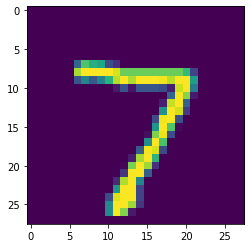

In [13]:
# Display the first image in test_dataset
import matplotlib.pyplot as plt
import numpy as np


def display_image(image):
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()


image = test_dataset[0][0]
print(type(image))
display_image(image)

In [14]:
import random


def random_image():
    example = test_dataset[random.randint(0, len(test_dataset)-1)][0]
    #display_image(example)
    encoded, result = model(example.view(1, input_dim))
    result = result.detach().view(1, 28, 28)
    #display_image(result)
    return encoded

In [15]:
random_image()

tensor([[-0.1217, -3.7919]], grad_fn=<AddmmBackward0>)

tensor([[ 0.0294, -1.6692]], grad_fn=<DivBackward0>)


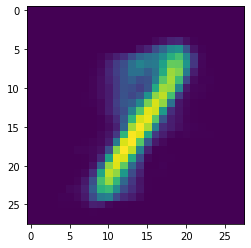

In [16]:
# See if the latent space is smooth by generating midpoints between known data
img1 = random_image()
img2 = random_image()

# Find the average of the two results
result = (img1 + img2) / 2
print(result)
# Run result through the decoder and display the result
result = model.decoder(result)
result = result.detach()
result = result.view(1, 28, 28)
result = result
display_image(result)

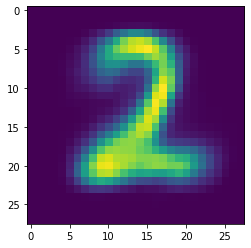

In [17]:
# View a pre-determined point in latent space
result = model.decoder(torch.tensor([[2.0, -2.0]]))
result = result.detach().view(1, 28, 28)
display_image(result)

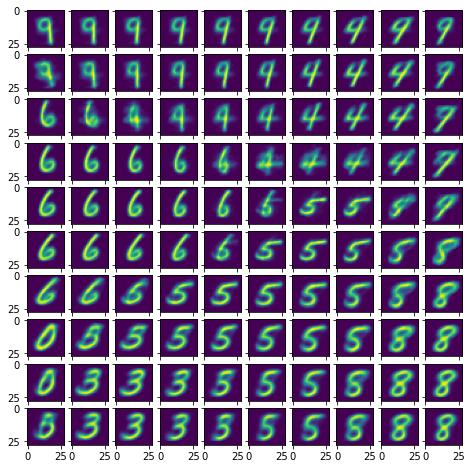

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

# Displays a 2d representation of the latent space
# The middle represents (0,0)
step = 10
size = 1
images = []
for i in range(step):
    for j in range(step):
        x = -size + i * (size*2)/(step-1)
        y = size - j * (size*2)/(step-1)
        result = model.decoder(torch.tensor([[x, y]]))
        result = result.detach().view(28,28)
        images.append(result)
        #print(x, y)

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(step, step),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()